In [1]:
import numpy as np
import torch
from torch import nn

## 1 - Positional Encoding


$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}
$$

<br>

$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}
$$

$$\theta(pos, i, d) = \frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$


In [3]:
def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding

    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size

    Returns:
        angles -- (pos, d) numpy array
    """

    # START CODE HERE
    # Get i from dimension span k
    i = k // 2
    # Calculate the angles using pos, i and d
    angles = pos / (10000 ** ((2 * i) / d))
    # END CODE HERE

    return angles

In [4]:
pos = np.arange(5).reshape(-1, 1)
k = np.arange(10).reshape(1, -1)

get_angles(pos, k, 10)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 1.58489319e-01, 1.58489319e-01,
        2.51188643e-02, 2.51188643e-02, 3.98107171e-03, 3.98107171e-03,
        6.30957344e-04, 6.30957344e-04],
       [2.00000000e+00, 2.00000000e+00, 3.16978638e-01, 3.16978638e-01,
        5.02377286e-02, 5.02377286e-02, 7.96214341e-03, 7.96214341e-03,
        1.26191469e-03, 1.26191469e-03],
       [3.00000000e+00, 3.00000000e+00, 4.75467958e-01, 4.75467958e-01,
        7.53565929e-02, 7.53565929e-02, 1.19432151e-02, 1.19432151e-02,
        1.89287203e-03, 1.89287203e-03],
       [4.00000000e+00, 4.00000000e+00, 6.33957277e-01, 6.33957277e-01,
        1.00475457e-01, 1.00475457e-01, 1.59242868e-02, 1.59242868e-02,
        2.52382938e-03, 2.52382938e-03]])

In [111]:
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings

    Arguments:
        positions (int) -- Maximum number of positions to be encoded
        d (int) -- Encoding size

    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles
    angle_rads = get_angles(
        torch.arange(positions).reshape(-1, 1), torch.arange(d).reshape(1, -1), d
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = torch.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = torch.cos(angle_rads[:, 1::2])
    # END CODE HERE

    pos_encoding = angle_rads[None, ...]

    return pos_encoding

torch.Size([1, 50, 512])


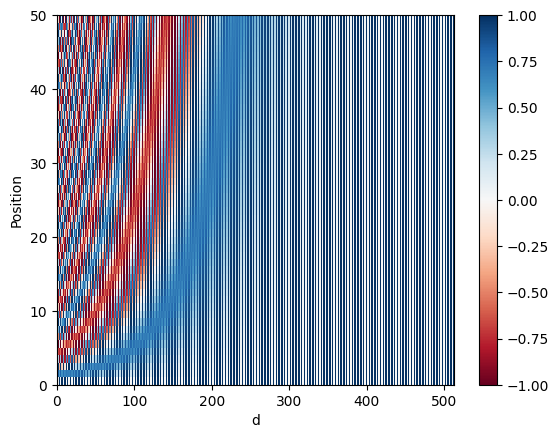

In [112]:
from matplotlib import pyplot as plt

pos_encoding = positional_encoding(50, 512)

print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap="RdBu")
plt.xlabel("d")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

## 2 - Masking


### 2.1 - Padding mask


In [7]:
def create_padding_mask(decoder_token_ids):
    """
    Creates a matrix mask for the padding cells

    Arguments:
        decoder_token_ids -- (n, m) matrix

    Returns:
        mask -- (n, 1, m) binary tensor
    """
    return (decoder_token_ids != 0)[:, None, :].float()

In [8]:
x = torch.tensor(
    [[7.0, 6.0, 0.0, 0.0, 1.0], [1.0, 2.0, 3.0, 0.0, 0.0], [0.0, 0.0, 0.0, 4.0, 5.0]]
)  # (3, 5)
padding_mask = create_padding_mask(x)  # (3, 1, 5)
print(padding_mask)

tensor([[[1., 1., 0., 0., 1.]],

        [[1., 1., 1., 0., 0.]],

        [[0., 0., 0., 1., 1.]]])


#### Computing attention using mask


In [9]:
# Q.Kt
# target seq len = 4
# source seq len = 5
Q_Kt = torch.rand((3, 4, 5))
print("Without mask :\n", torch.softmax(Q_Kt, dim=-1))
print(
    "With mask :\n",
    torch.softmax(Q_Kt.masked_fill(padding_mask == 0, float("-inf")), dim=-1),
)  # Set to -inf to have attention coefficient set to 0 after softmax for padding tokens

Without mask :
 tensor([[[0.1784, 0.2255, 0.1144, 0.2649, 0.2168],
         [0.1323, 0.1624, 0.2962, 0.2279, 0.1812],
         [0.2886, 0.1522, 0.2263, 0.1499, 0.1830],
         [0.1350, 0.2913, 0.2008, 0.2408, 0.1320]],

        [[0.2581, 0.1602, 0.1797, 0.2300, 0.1719],
         [0.1541, 0.1574, 0.2958, 0.1643, 0.2283],
         [0.1545, 0.2156, 0.1381, 0.2732, 0.2185],
         [0.1350, 0.1675, 0.1378, 0.2069, 0.3529]],

        [[0.2366, 0.2006, 0.1204, 0.2566, 0.1859],
         [0.2377, 0.1564, 0.2368, 0.2377, 0.1315],
         [0.1407, 0.2246, 0.1482, 0.2370, 0.2495],
         [0.3320, 0.1931, 0.1359, 0.1960, 0.1431]]])
With mask :
 tensor([[[0.2874, 0.3633, 0.0000, 0.0000, 0.3493],
         [0.2780, 0.3413, 0.0000, 0.0000, 0.3807],
         [0.4627, 0.2439, 0.0000, 0.0000, 0.2934],
         [0.2418, 0.5217, 0.0000, 0.0000, 0.2365]],

        [[0.4315, 0.2679, 0.3005, 0.0000, 0.0000],
         [0.2538, 0.2591, 0.4871, 0.0000, 0.0000],
         [0.3040, 0.4242, 0.2718, 0.0000, 0.0

### 2.2 - Look ahead masking


In [10]:
def create_look_ahead_mask(sequence_length):
    """
    Returns a lower triangular matrix filled with ones

    Arguments:
        sequence_length -- matrix size

    Returns:
        mask -- (size, size) tensor
    """
    return torch.tril(torch.ones(1, sequence_length, sequence_length))

In [11]:
x = torch.rand((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

tensor([[[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]])

## 3- Self Attention


$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$


In [12]:
import math


def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead)
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """

    matmul_qk = torch.matmul(q, k.T)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = k.shape[-1]
    scaled_attention_logits = matmul_qk / math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:  # Don't replace this None
        scaled_attention_logits = scaled_attention_logits.masked_fill(
            mask == 0, float("-inf")
        )

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = torch.softmax(
        scaled_attention_logits, dim=-1
    )  # (..., seq_len_q, seq_len_k)

    output = torch.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 4 - Encoder


In [13]:
from torch import Tensor


class FullyConnected(nn.Module):
    def __init__(self, embedding_dim, fully_connected_dim) -> None:
        super(FullyConnected, self).__init__()
        self.linear1 = nn.Linear(embedding_dim, fully_connected_dim)
        self.linear2 = nn.Linear(fully_connected_dim, embedding_dim)

    def forward(self, x: Tensor):
        return self.linear2(self.linear1(x).relu())

In [16]:
embedding_dim = 4
fc = FullyConnected(embedding_dim, 5)
fc(torch.rand((3, 6, embedding_dim))).shape

torch.Size([3, 6, 4])

### 4.1 - Encoder Layer


In [31]:
class EncoderLayer(nn.Module):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network.
    This architecture includes a residual connection around each of the two
    sub-layers, followed by layer normalization.
    """

    def __init__(
        self,
        embedding_dim,
        num_heads,
        fully_connected_dim,
        dropout_rate=0.1,
        layernorm_eps=1e-6,
    ):
        super(EncoderLayer, self).__init__()

        self.mha = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )
        self.layernorm1 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)
        self.fc = FullyConnected(
            embedding_dim=embedding_dim, fully_connected_dim=fully_connected_dim
        )
        self.dropout = nn.Dropout(p=dropout_rate)
        self.layernorm2 = nn.LayerNorm(embedding_dim, eps=layernorm_eps)

    def forward(self, x, mask):
        # Multi Head Attention
        self_mha_output, _ = self.mha(x, x, x, mask, need_weights=False)
        # Add and Norm
        skip_x_attention = self.layernorm1(self_mha_output + x)
        # Fully Connected
        ffn_output = self.fc(skip_x_attention)
        # Dropout
        ffn_output = self.dropout(ffn_output)
        # Add and Norm
        encoder_layer_out = self.layernorm2(ffn_output + skip_x_attention)

        return encoder_layer_out

In [38]:
e = EncoderLayer(embedding_dim=4, num_heads=2, fully_connected_dim=5)
e(
    torch.rand((3, 6, 4)),
    torch.tensor([[0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 0, 1], [0, 0, 0, 1, 1, 1]]).bool(),
).shape

torch.Size([3, 6, 4])

### 4.2 - Full Encoder


In [113]:
class Encoder(nn.Module):
    """
    The entire Encoder starts by passing the input to an embedding layer
    and using positional encoding to then pass the output through a stack of
    encoder Layers

    """

    def __init__(
        self,
        num_layers,
        embedding_dim,
        num_heads,
        fully_connected_dim,
        input_vocab_size,
        maximum_position_encoding,
        dropout_rate=0.1,
        layernorm_eps=1e-6,
    ):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim

        self.embedding = nn.Embedding(
            num_embeddings=input_vocab_size, embedding_dim=embedding_dim, padding_idx=0
        )

        self.positional_encoding = positional_encoding(
            maximum_position_encoding, embedding_dim
        )

        self.enc_layers = nn.ModuleList(
            [
                EncoderLayer(
                    embedding_dim,
                    num_heads,
                    fully_connected_dim,
                    dropout_rate,
                    layernorm_eps,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        seq_len = x.shape[1]

        x = self.embedding(x)

        x *= math.sqrt(self.embedding_dim)

        x = x + self.positional_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for encoder in self.enc_layers:
            x = encoder(x, mask)

        return x

## 5 - Decoder


### 5.1 - Decoder Layer


In [145]:
class DecoderLayer(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_heads,
        fully_connected_dim,
        dropout_rate=0.1,
        layernorm_eps=1e-6,
    ) -> None:
        super(DecoderLayer, self).__init__()

        self.mha1 = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        self.layernorm1 = nn.LayerNorm(embedding_dim, layernorm_eps)

        self.mha2 = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout_rate,
            batch_first=True,
        )

        self.layernorm2 = nn.LayerNorm(embedding_dim, layernorm_eps)

        self.ffn = FullyConnected(
            embedding_dim=embedding_dim, fully_connected_dim=fully_connected_dim
        )

        self.dropout_ffn = nn.Dropout(dropout_rate)

        self.layernorm3 = nn.LayerNorm(embedding_dim, layernorm_eps)

    def forward(self, x, enc_output, padding_mask, attention_mask):
        self_mha_output, attn_weights_block1 = self.mha1(
            x, x, x, attn_mask=attention_mask, need_weights=True
        )

        x = self.layernorm1(x + self_mha_output)

        cross_mha_output, attn_weights_block2 = self.mha2(
            x, enc_output, enc_output, key_padding_mask=padding_mask, need_weights=True
        )

        x = self.layernorm2(x + cross_mha_output)

        ffn_output = self.ffn(x)

        ffn_output = self.dropout_ffn(ffn_output)

        x = self.layernorm3(x + ffn_output)

        return x, attn_weights_block1, attn_weights_block2

In [147]:
dec_layer = DecoderLayer(embedding_dim=6, num_heads=2, fully_connected_dim=12)

x = torch.rand((3, 4, 6))
k = v = torch.rand((3, 5, 6))

# Masks are converted to the format expected by pytorch MHA
attention_mask = ~create_look_ahead_mask(4).bool().reshape(4, 4)
padding_mask = ~create_padding_mask(
    torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 0], [1, 2, 3, 0, 0]])
).bool().reshape(-1, 5)

output, attn1, attn2 = dec_layer(x, k, padding_mask, attention_mask)

print(output.shape, attn1.shape, attn2.shape)

torch.Size([3, 4, 6]) torch.Size([3, 4, 4]) torch.Size([3, 4, 5])


### 5.2 - Full Decoder


In [149]:
class Decoder(nn.Module):
    def __init__(
        self,
        num_layers,
        embedding_dim,
        num_heads,
        fully_connected_dim,
        target_vocab_size,
        maximum_position_encoding,
        dropout_rate=0.1,
        layernorm_eps=1e-6,
    ) -> None:
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(
            num_embeddings=target_vocab_size, embedding_dim=embedding_dim
        )

        self.positional_encoding = positional_encoding(
            maximum_position_encoding, embedding_dim
        )

        self.dropout = nn.Dropout(dropout_rate)

        self.decoder_layers = nn.ModuleList(
            [
                DecoderLayer(
                    embedding_dim,
                    num_heads,
                    fully_connected_dim,
                    dropout_rate,
                    layernorm_eps,
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x, enc_output, padding_mask, attention_mask):
        seq_len = x.shape[1]

        attention_weights = {}

        x = self.embedding(x)
        x *= math.sqrt(self.embedding_dim)
        x += self.positional_encoding[:, :seq_len, :]
        x = self.dropout(x)

        for i, decoder_layer in enumerate(self.decoder_layers):
            x, attn1, attn2 = decoder_layer(x, enc_output, padding_mask, attention_mask)

            attention_weights["decoder_layer{}_block1_self_att".format(i + 1)] = attn1
            attention_weights["decoder_layer{}_block2_decenc_att".format(i + 1)] = attn2

        return x, attention_weights

In [152]:
x = torch.tensor([[1, 2, 3, 4], [1, 2, 0, 0], [1, 2, 3, 0]])
k = v = torch.rand((3, 5, 6))

attention_mask = ~create_look_ahead_mask(4).bool().reshape(4, 4)
padding_mask = ~create_padding_mask(
    torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 0], [1, 2, 3, 0, 0]])
).bool().reshape(-1, 5)

decoder = Decoder(2, 6, 2, 12, 5, 5)

output, *_ = decoder(x, k, padding_mask, attention_mask)

output.shape

torch.Size([3, 4, 6])

## 6 - Transformer


In [154]:
class Transformer(nn.Module):
    def __init__(
        self,
        num_layers,
        embedding_dim,
        num_heads,
        fully_connected_dim,
        input_vocab_size,
        target_vocab_size,
        max_positional_encoding_input,
        max_positional_encoding_target,
        dropout_rate=0.1,
        layernorm_eps=1e-6,
    ):
        super(Transformer, self).__init__()

        self.encoder = Encoder(
            num_layers=num_layers,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            fully_connected_dim=fully_connected_dim,
            input_vocab_size=input_vocab_size,
            maximum_position_encoding=max_positional_encoding_input,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps,
        )

        self.decoder = Decoder(
            num_layers=num_layers,
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            fully_connected_dim=fully_connected_dim,
            target_vocab_size=target_vocab_size,
            maximum_position_encoding=max_positional_encoding_target,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps,
        )

        self.final_layer = nn.Linear(embedding_dim, target_vocab_size)

    def forward(self, inp, tar, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, enc_padding_mask)
        dec_output = self.decoder(tar, enc_output, dec_padding_mask, look_ahead_mask)

        return self.final_layer(dec_output).softmax(dim=-1)

In [155]:
Transformer(2, 6, 2, 12, 5, 5, 5, 5)

Transformer(
  (encoder): Encoder(
    (embedding): Embedding(5, 6, padding_idx=0)
    (enc_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out_features=6, bias=True)
        )
        (layernorm1): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
        (fc): FullyConnected(
          (linear1): Linear(in_features=6, out_features=12, bias=True)
          (linear2): Linear(in_features=12, out_features=6, bias=True)
        )
        (dropout): Dropout(p=0.1, inplace=False)
        (layernorm2): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5, 6)
    (dropout): Dropout(p=0.1, inplace=False)
    (decoder_layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (mha1): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=6, out

### Bonus : Multi Head Attention


In [33]:
import math


def scaled_dot_product_attention(q, k, v, mask):
    q_kt = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(k.shape[-1])
    if mask is not None:
        q_kt = q_kt.masked_fill(mask, float("-inf"))

    attention_weights = torch.softmax(q_kt, dim=-1)

    output = torch.matmul(attention_weights, v)

    return output, attention_weights

In [47]:
class MultiHeadAttention(nn.Module):
    def __init__(
        self, embedding_dim, num_heads, kdim=None, vdim=None, dropout_rate=0.1
    ) -> None:
        super(MultiHeadAttention, self).__init__()

        if kdim is None:
            kdim = embedding_dim
        if vdim is None:
            vdim = embedding_dim

        self.wq = nn.Parameter(torch.rand((embedding_dim, embedding_dim)))
        self.wk = nn.Parameter(torch.rand((embedding_dim, kdim)))
        self.wv = nn.Parameter(torch.rand((embedding_dim, vdim)))
        self.wo = nn.Parameter(torch.rand((embedding_dim, embedding_dim)))

        self.dropout = nn.Dropout(dropout_rate)

        self.num_heads = num_heads

    def forward(
        self,
        q,
        k,
        v,
        key_padding_mask: torch.BoolTensor = None,
        attention_mask: torch.BoolTensor = None,
    ):
        """
        q: (N, L, de)
        k: (N, S, dk)
        v: (N, S, dv)
        """
        batch_size = q.shape[0]
        target_seq_len = q.shape[1]
        source_seq_len = k.shape[1]

        q = torch.matmul(q, self.wq.T)  # (N, L, de)
        k = torch.matmul(k, self.wk.T)  # (N, S, de)
        v = torch.matmul(v, self.wv.T)  # (N, S, de)

        q = q.reshape((batch_size, self.num_heads, target_seq_len, -1))  # (N, h, L, dh)
        k = k.reshape((batch_size, self.num_heads, source_seq_len, -1))  # (N, h, S, dh)
        v = v.reshape((batch_size, self.num_heads, source_seq_len, -1))  # (N, h, S, dh)

        mask = None
        if key_padding_mask is not None and attention_mask is not None:
            attention_mask = key_padding_mask | attention_mask
        elif key_padding_mask is not None:
            mask = key_padding_mask
        elif attention_mask is not None:
            mask = attention_mask

        attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

        attention = attention.reshape(batch_size, target_seq_len, -1)  # (N, L, de)

        output = torch.matmul(attention, self.wo.T)  # (N, L, de)

        output = self.dropout(output)

        return output, attention_weights

In [59]:
x = torch.rand((3, 5, 4))
x

tensor([[[0.4010, 0.4621, 0.4050, 0.3157],
         [0.7087, 0.3297, 0.2191, 0.6134],
         [0.1386, 0.3933, 0.7555, 0.6869],
         [0.9257, 0.1590, 0.5043, 0.3523],
         [0.2203, 0.2187, 0.6260, 0.5523]],

        [[0.2448, 0.1476, 0.0857, 0.9900],
         [0.4148, 0.3844, 0.3161, 0.2499],
         [0.0427, 0.2065, 0.8056, 0.6096],
         [0.3236, 0.3110, 0.8194, 0.8604],
         [0.9817, 0.6459, 0.7416, 0.4598]],

        [[0.2077, 0.0102, 0.8045, 0.4273],
         [0.7054, 0.5246, 0.0333, 0.2547],
         [0.6407, 0.3988, 0.0172, 0.6753],
         [0.5192, 0.3393, 0.7020, 0.6056],
         [0.3156, 0.9492, 0.7508, 0.5628]]])

In [74]:
mask = torch.tensor([[False, True, False, False, True]])

mha = MultiHeadAttention(4, 2)

# Print attention weights
mha(x, x, x, mask)[1]

tensor([[[[0.2949, 0.0000, 0.3796, 0.3255, 0.0000],
          [0.2668, 0.0000, 0.4160, 0.3172, 0.0000],
          [0.2857, 0.0000, 0.3927, 0.3216, 0.0000],
          [0.2564, 0.0000, 0.4305, 0.3131, 0.0000],
          [0.2878, 0.0000, 0.3881, 0.3241, 0.0000]],

         [[0.3471, 0.0000, 0.4214, 0.2314, 0.0000],
          [0.3349, 0.0000, 0.3887, 0.2764, 0.0000],
          [0.3379, 0.0000, 0.4063, 0.2558, 0.0000],
          [0.3404, 0.0000, 0.3733, 0.2863, 0.0000],
          [0.3445, 0.0000, 0.4027, 0.2528, 0.0000]]],


        [[[0.3712, 0.0000, 0.3131, 0.3157, 0.0000],
          [0.3968, 0.0000, 0.3068, 0.2964, 0.0000],
          [0.3668, 0.0000, 0.3174, 0.3158, 0.0000],
          [0.3900, 0.0000, 0.3066, 0.3033, 0.0000],
          [0.3675, 0.0000, 0.3196, 0.3129, 0.0000]],

         [[0.1731, 0.0000, 0.2912, 0.5357, 0.0000],
          [0.2037, 0.0000, 0.3044, 0.4919, 0.0000],
          [0.1275, 0.0000, 0.2616, 0.6109, 0.0000],
          [0.1729, 0.0000, 0.2887, 0.5384, 0.0000],
    

In [63]:
mask = torch.tril(torch.ones(1, 5, 5)) == 0

mha = MultiHeadAttention(4, 2)

# Print attention weights
mha(x, x, x, mask)[1]

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5201, 0.4799, 0.0000, 0.0000, 0.0000],
          [0.3230, 0.2940, 0.3829, 0.0000, 0.0000],
          [0.2570, 0.2325, 0.2924, 0.2181, 0.0000],
          [0.1951, 0.1866, 0.2230, 0.1931, 0.2022]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4812, 0.5188, 0.0000, 0.0000, 0.0000],
          [0.3432, 0.3814, 0.2754, 0.0000, 0.0000],
          [0.2721, 0.2708, 0.2441, 0.2130, 0.0000],
          [0.2102, 0.2208, 0.1870, 0.1948, 0.1872]]],


        [[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5256, 0.4744, 0.0000, 0.0000, 0.0000],
          [0.3364, 0.3089, 0.3547, 0.0000, 0.0000],
          [0.2635, 0.2204, 0.2686, 0.2475, 0.0000],
          [0.1927, 0.1963, 0.2095, 0.1989, 0.2025]],

         [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4801, 0.5199, 0.0000, 0.0000, 0.0000],
          [0.2892, 0.3734, 0.3374, 0.0000, 0.0000],
          [0.1625, 0.2165, 0.2244, 0.3967, 0.0000],
    